Commands used:

```
predictThermodynamicEnhancosomeModel.py -M ../EBound2_progressive_learning_pTpA_Glu.ACPMB.pos.Model -i $1 -o $2.YPD.biochem.preds.gz -sl 110 


predictThermodynamicEnhancosomeModel.py -M ../EBound2_progressive_learning_pTpA_SC-Ura.ACPMBOL.Model -i $1 -o $2.SDUra.biochem.preds.gz -sl 110
```

For more details, please check out : https://github.com/de-Boer-Lab/CisRegModels

Note: Both are position-aware models

Each file has 3 columns: measured expression; predicted expression; predicted accessibility

We use the complex media for the figures here by default. The defined media results are saved in this directory. As noted everywhere in the manuscript and code, the complex and defined media have equivalent predicted and measured expression levels and equivalent results will be obtained by using the defined media here.

In [1]:

import tensorflow.keras as keras  ## important to make sure non tf.keras is hidden

### Reference to helpful open sourced libraries utilized in this project : 
##https://github.com/CyberZHG ### Thanks CyberZHG ! 
#from keras_multi_head import MultiHeadAttention , MultiHead
#from keras_position_wise_feed_forward import FeedForward
#from keras_layer_normalization import LayerNormalization 
##https://github.com/CyberZHG
#http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=9 


import argparse,pwd,os,numpy as np,h5py
from os import makedirs
from os.path import splitext,exists,dirname,join,basename , realpath
import multiprocessing as mp, ctypes
from sklearn.metrics import *
from scipy.stats import *
import time , csv ,pickle ,joblib , matplotlib  , multiprocessing,itertools
from joblib import Parallel, delayed 
import seaborn as sns
import os, gc , datetime , sklearn , scipy , pydot , random  
from tqdm import tqdm 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.keras import Input
from tensorflow.keras.layers import  Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten , Conv1D, Concatenate , Permute
from tensorflow.keras.layers import Bidirectional,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Add , LeakyReLU ,Reshape , Activation , MaxPooling1D , Lambda , Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.backend import conv1d
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import h5py , tensorflow
import tensorflow as tf, sys, numpy as np, h5py, pandas as pd
from tensorflow import nn
from os import makedirs
#from tensorflow.keras.utils import multi_gpu_model
import glob , math




##Matplotlib rc params
# Font family : https://matplotlib.org/tutorials/introductory/customizing.html , http://aeturrell.com/2018/01/31/publication-quality-plots-in-python/ , https://www.dmcdougall.co.uk/publication-ready-the-first-time-beautiful-reproducible-plots-with-matplotlib , https://stackoverflow.com/questions/26106552/matplotlib-style-library-not-updating-when-mplstyle-files-added-deleted , https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html , http://www.jesshamrick.com/2016/04/13/reproducible-plots/ , 
#
from matplotlib import rcParams
rcParams.update(matplotlib.rcParamsDefault)
rcParams['pdf.fonttype'] = 42
sns.set(context = 'paper' , style='ticks' , 
        rc = {
            'figure.autolayout' : True,
            'axes.titlesize' : 8 ,
            'axes.titleweight' :'bold',
            
            'figure.titleweight' : 'bold' ,
            'figure.titlesize' : 8 ,
            
            'axes.labelsize' : 8 ,
            'axes.labelpad' : 2 ,
            'axes.labelweight' : 'bold' , 
            'axes.spines.top' : False,
            'axes.spines.right' : False,
            
            'xtick.labelsize' : 7 ,
            'ytick.labelsize' : 7 ,
            
            'legend.fontsize' : 7 ,
            'figure.figsize' : (3.5, 3.5/1.6 ) ,          
            
            'xtick.direction' : 'out' ,
            'ytick.direction' : 'out' ,
            
            'xtick.major.size' : 2 ,
            'ytick.major.size' : 2 ,
            
            'xtick.major.pad' : 2,
            'ytick.major.pad' : 2,
            
            #'lines.linewidth' : 1            
            
             } )


##

/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3

# Random Test Data (corresponding to Fig. 1b) and Native Test Data ( corresponding to Fig. 1c)

In [74]:
tpu_df

,sequence,Measured Expression,Predicted Expression
0,NNNNNNNNNNTGCATTTTTTTCACAAGAGCACTTGAAGGGCGCCTA...,13.708592,13.144622
1,NNNTGCATTTTTTTCACACATATACTTGGGTGACTTAGATATTTGC...,2.553335,4.590216
2,NTGCATTTTTTTCACACATCTGGATTGTCTGGTGTGCTGGTATCTT...,13.369969,13.149384
3,NTGCATTTTTTTCACACCACCGTGGGGATTCGCAGCTATGTGCATA...,3.328683,5.131679
4,NNTGCATTTTTTTCACACCATGGATTTAAGAATTAATCACCGGACA...,10.466688,11.301416
...,...,...,...
9977,NNTGCATTTTTTTCACTCTTTCACGTGGGGCCTGCGGGGTATCGGT...,14.962475,15.238556
9978,NNNNNNNNNNNNTGCATTTTTTTCACTGATGTGGTGCGCGTAATTT...,11.999880,13.480228
9979,TGCATTTTTTTCACTTCCAGTAATATGCGAAAGGGTGATGTGAACT...,4.541188,6.266724
9980,NNNNNNNNNNNNNNTGCATTTTTTTCACTTCGCACTCCACTTCTCG...,7.456650,11.376089


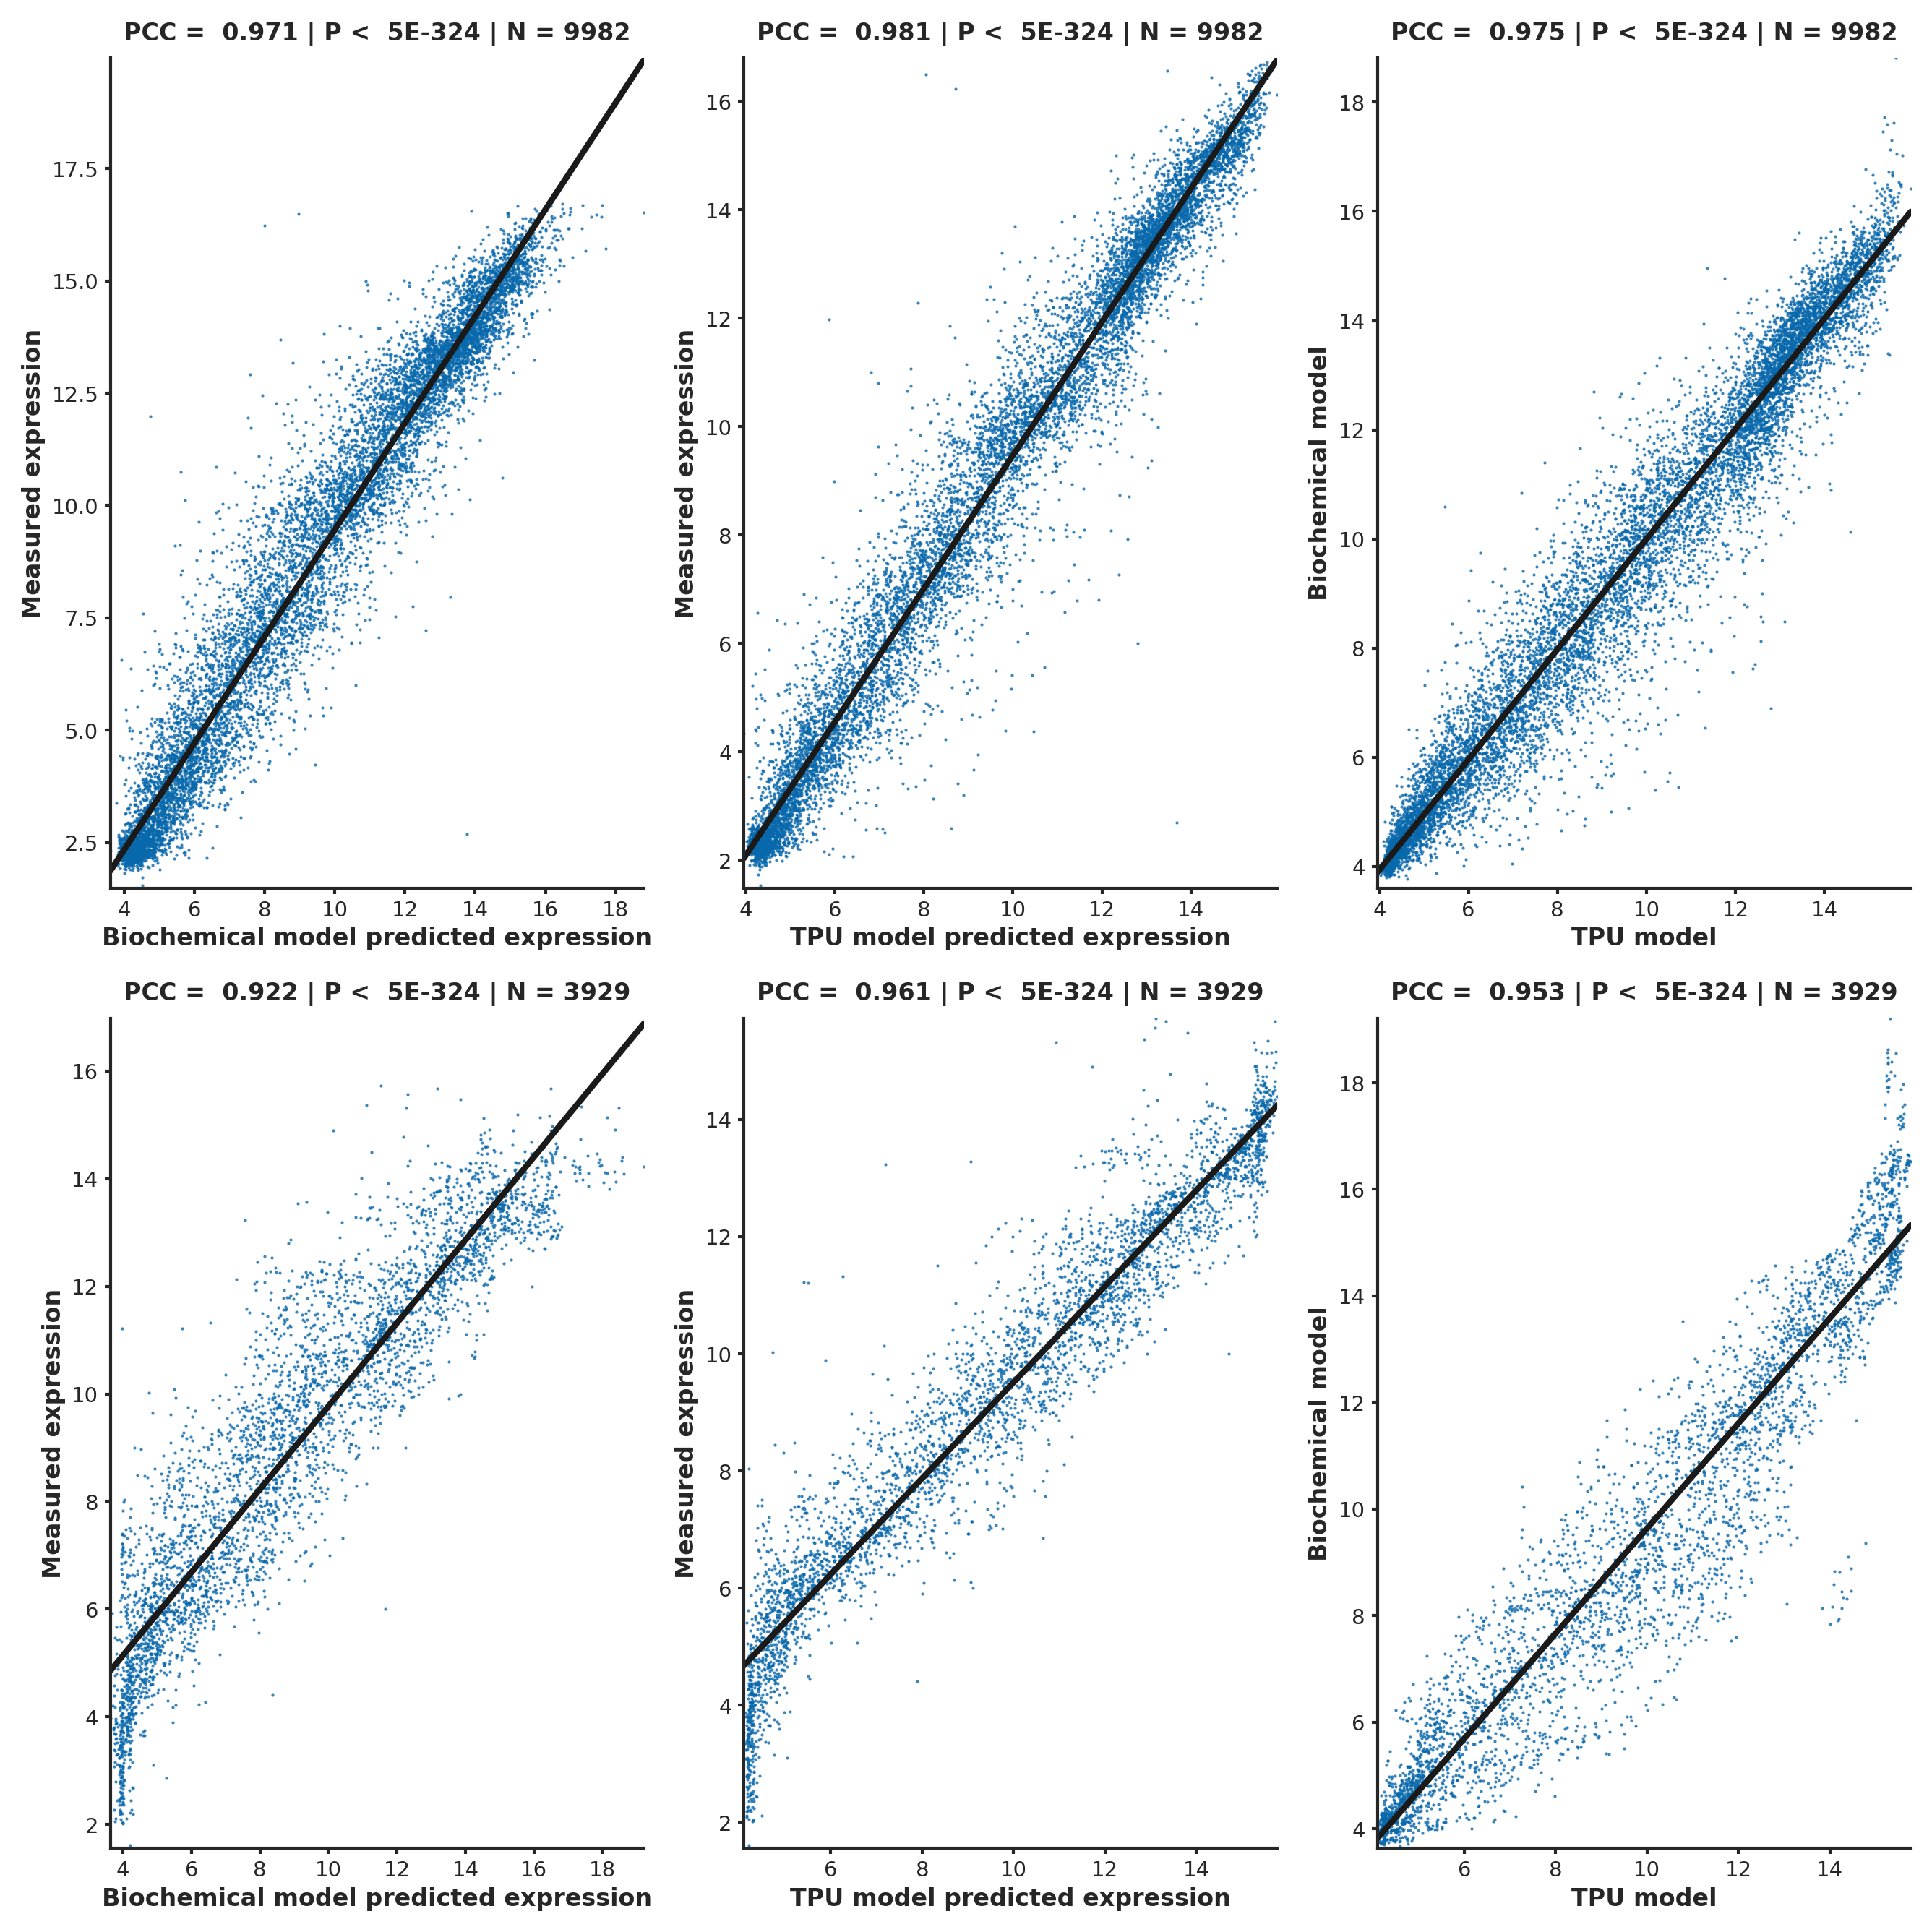

In [86]:

model_name = 'Biochemical model'

fig_file = model_name+" prediction_performance_all"

fig=plt.figure(figsize=(9,9) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)


for i in range(6)  : 
    plt.subplot(2,3,i+1)

    if i==0 : 
        biochemical_df = pd.read_csv('HQ_testdata.YPD.biochem.preds.gz',sep= '\t')
        expressions = biochemical_df['actual'].values
        predicted_expressions = biochemical_df['predicted'].values
        xlabel = "Biochemical model predicted expression"
        ylabel = "Measured expression"

    if i==1 :
        tpu_df = pd.read_csv('../../../results_summary/Random_test_tpu_model.csv', index_col = 0)
        #biochemical_df = pd.read_csv('HQ_testdata.YPD.biochem.preds.gz',sep= '\t')
        expressions = tpu_df['Measured Expression'].values
        predicted_expressions = tpu_df['Predicted Expression'].values
        xlabel = "TPU model predicted expression"
        ylabel = "Measured expression"
        
    if i==2 :
        tpu_df = pd.read_csv('../../../results_summary/Random_test_tpu_model.csv', index_col = 0)
        biochemical_df = pd.read_csv('HQ_testdata.YPD.biochem.preds.gz',sep= '\t')
        expressions = biochemical_df['predicted'].values
        predicted_expressions = tpu_df['Predicted Expression'].values
        xlabel = "TPU model"
        ylabel = "Biochemical model"
        
    if i==3 : 
        biochemical_df = pd.read_csv('Native_testdata.YPD.biochem.preds.gz',sep= '\t')
        expressions = biochemical_df['actual'].values
        predicted_expressions = biochemical_df['predicted'].values
        xlabel = "Biochemical model predicted expression"
        ylabel = "Measured expression"

    if i==4 :
        tpu_df = pd.read_csv('../../../results_summary/Native_test_tpu_model.csv', index_col = 0)
        #biochemical_df = pd.read_csv('HQ_testdata.YPD.biochem.preds.gz',sep= '\t')
        expressions = tpu_df['Measured Expression'].values
        predicted_expressions = tpu_df['Predicted Expression'].values
        xlabel = "TPU model predicted expression"
        ylabel = "Measured expression"
        
    if i==5 :
        tpu_df = pd.read_csv('../../../results_summary/Native_test_tpu_model.csv', index_col = 0)
        biochemical_df = pd.read_csv('Native_testdata.YPD.biochem.preds.gz',sep= '\t')
        expressions = biochemical_df['predicted'].values
        predicted_expressions = tpu_df['Predicted Expression'].values
        xlabel = "TPU model"
        ylabel = "Biochemical model"
              
    x = list(predicted_expressions)
    y = list(expressions)

    r = scipy.stats.pearsonr(x ,y )
    sns.regplot(x=x ,y=y ,
                scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
                line_kws= {'linewidth':2} ,
               color= '#0868ac', robust = 1 )



    ax = plt.gca()
    #ax.get_legend().remove()


    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if (r[1] ==0.0) :
        ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
    else :
        ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


    plt.setp(ax.artists, edgecolor = 'k')
    plt.setp(ax.lines, color='k')
    #plt.setp(ax.lines, linewidth=1.5)

    ax.autoscale(enable=True, axis='x', tight=True)
    ax.autoscale(enable=True, axis='y', tight=True)
    #ax.set_xlim(xmin=-8,xmax=8)
    #ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

<Figure size 350x218.75 with 0 Axes>